## ÖAW AI Workshop Classification Challenge

https://www.kaggle.com/c/oeawai/overview

For this years challenge we will train a machine learning algorithm to classify instrument sounds according to their families.

We will be using an audio dataset that contains 269,776 musical notes, each with a unique pitch, timbre, and envelope. It was generated by sampling instruments from commercial sample libraries. Each sample is a four seconds, monophonic 16kHz audio snippet, referred to as notes. The notes were generated by ranging over every pitch of a standard MIDI piano (21-108) as well as five different velocities (25, 50, 75, 100, 127). The note was held for the first three seconds and allowed to decay for the final second. Some instruments are not capable of producing all 88 pitches in this range, resulting in an average of 65.4 pitches per instrument. Furthermore, the commercial sample packs occasionally contain duplicate sounds across multiple velocities, leaving an average of 4.75 unique velocities per pitch. 

In [1]:
import csv
import time

import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
#import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

from types import SimpleNamespace

import librosa

from trainDataset import TrainDataset
from testDataset import TestDataset

### Examining data

https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

In [2]:
toFloat = transforms.Lambda(lambda x: x / np.iinfo(np.int16).max)
trainDataset = TrainDataset("../data/kaggle-train-small/", transform=toFloat, blacklist_patterns=["synthetic", "string"])
testDataset = TestDataset("../data/kaggle-test", transform=toFloat)
print(len(trainDataset))
print(len(testDataset))

6783
4096


#### Examining one test sample batch

In [14]:
batch_size = 32
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! shuffle should be false
for samples in testloader:
        print(samples.shape)
        print(torch.min(samples), torch.max(samples))
        break

torch.Size([32, 64000])
tensor(-1., dtype=torch.float64) tensor(1., dtype=torch.float64)


#### Examining one train sample batch

In [15]:
batch_size = 16
trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

for samples, instrument_family_target in trainLoader:
        print("samples shape: {}".format(samples.shape))
        print("instrument family shape: {}".format(instrument_family_target.shape)) 
        print("instrument family target: {}".format(instrument_family_target.data))
        print("minimum: {}".format(torch.min(samples)))
        print("maximum: {}".format(torch.max(samples)))
        print("instrument: {}".format(trainDataset.transformInstrumentsFamilyToString(instrument_family_target.data)))
        break

samples shape: torch.Size([16, 64000])
instrument family shape: torch.Size([16])
instrument family target: tensor([4, 0, 6, 7, 6, 4, 6, 6, 7, 6, 4, 3, 6, 5, 6, 7])
minimum: -0.9417401654103214
maximum: 0.9467146824549089
instrument: ['keyboard' 'bass' 'organ' 'reed' 'organ' 'keyboard' 'organ' 'organ'
 'reed' 'organ' 'keyboard' 'guitar' 'organ' 'mallet' 'organ' 'reed']


#### Examining the min and max values from tensors and bulding dataframe

In [8]:
batch_size = 1
trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
targets = []
mins = []
maxs = []
diffs = []

for samples, instrument_family_target in trainLoader:
    mins.append(torch.min(samples).tolist())
    maxs.append(torch.max(samples).tolist())
    diffs.append(torch.max(samples).tolist() - torch.min(samples).tolist())
    targets.append(instrument_family_target.data.tolist()[0])

df_sounds = pd.DataFrame(zip(mins, maxs, diffs, targets), columns = ["min", "max", "diffs", "instrument"])
df_sounds.head()

,min,max,diffs,instrument
0,-0.484451,0.896146,1.380596,1
1,-0.673452,0.777917,1.451369,4
2,-0.594653,0.711417,1.306070,7
3,-0.904569,0.945769,1.850337,3
4,-0.912473,0.749504,1.661977,3


In [9]:
df_sounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6783 entries, 0 to 6782
Data columns (total 4 columns):
min           6783 non-null float64
max           6783 non-null float64
diffs         6783 non-null float64
instrument    6783 non-null int64
dtypes: float64(3), int64(1)
memory usage: 212.1 KB


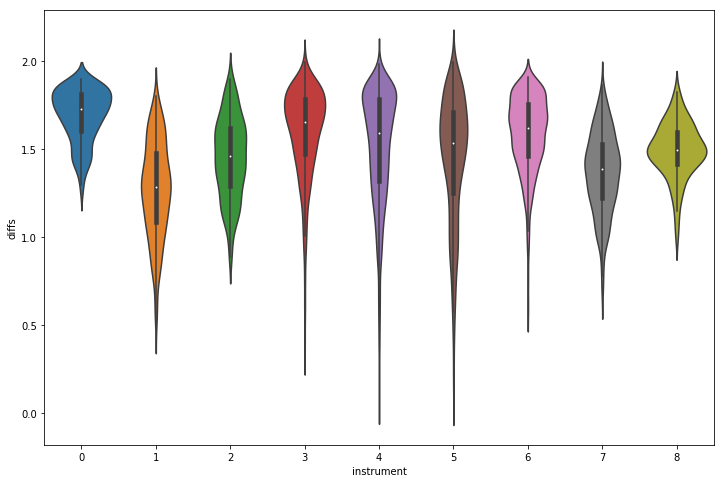

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="instrument", y="diffs", data=df_sounds)
#df_sounds.groupby("instrument").mean().plot(ax=ax)

Let's define a way to transform the time-domain audio signals into time-frequency domain. It is always a good idea to plot the data to make sure the preprocessing is doing what we want it to do. 

In [11]:
def logMagStft(numpyArray, sample_rate, n_fft):
    f, t, sx = sc.signal.stft(numpyArray, fs=sample_rate, nperseg=n_fft, noverlap=n_fft//2) 
    return np.log(np.abs(sx)+np.e**-10)

Now let's measure the amount of energy in different frequency bands for all the signals. The assumption is that instruments from different families will have their energy distributed differently accross frequencies.

In [16]:
def computeMelspectrogram(numpyArray, sample_rate):
    S = librosa.feature.melspectrogram(y=numpyArray, sr=sample_rate, n_mels=128, fmax=8000)
    return np.log(S+1e-4)
sample_rate = 16000

Plotting some graphs

In [64]:
batch_size = 16
number_of_examples_to_plot = 16
n_fft = 510
sample_rate = 16000
spectrograms = np.zeros((number_of_examples_to_plot, n_fft//2+1, int(2*64000/n_fft)+2))
mfccs = np.zeros((batch_size, 128))

trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

for samples, instrumentsFamily in trainLoader:
    for index in range(number_of_examples_to_plot):
        spectrograms[index] = logMagStft(samples[index].numpy(), sample_rate, n_fft)
        mfccs[index] = np.mean(computeMelspectrogram(samples[index].numpy(), sample_rate), axis=1)
    family = trainDataset.transformInstrumentsFamilyToString(instrumentsFamily.numpy().astype(int))
    break

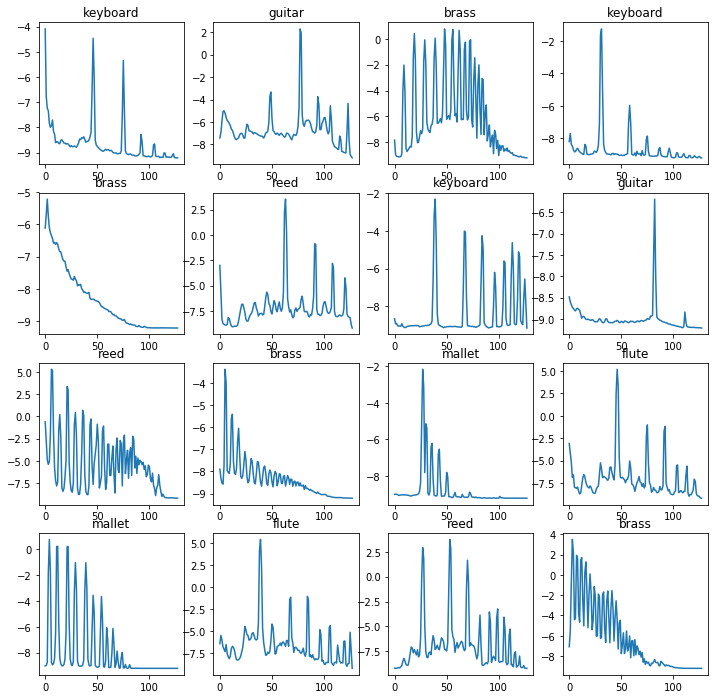

In [65]:
f, ax = plt.subplots(4, 4, figsize=(12,12))
#for i in range(batch_size):
for column in range(4):
    for line in range(4):
        #print(line+column*4)
        #plt.plot(mfccs[i])
        ax[line,column].plot(mfccs[line+column*4])
        #print(family[i])
        ax[line,column].set_title(family[line+column*4])
plt.show()

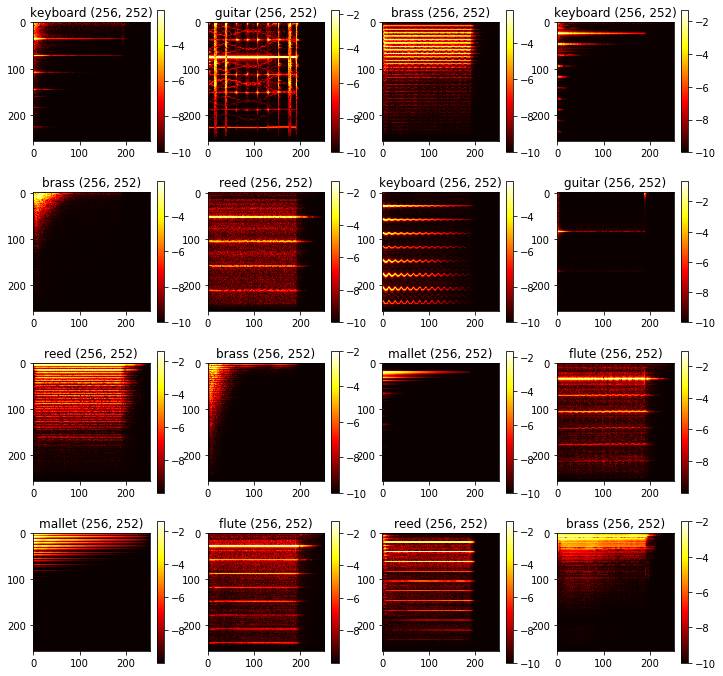

In [66]:
f, ax = plt.subplots(4, 4, figsize=(12,12))
#for i in range(batch_size):
for column in range(4):
    for line in range(4):
        ax[line,column].imshow(spectrograms[line+column*4,:,:], cmap='hot')
        title = str(family[line+column*4]) + ' ' + str(spectrograms[line+column*4].shape)
        ax[line,column].set_title(title)
        clb = ax[line,column].imshow(spectrograms[line+column*4,:,:], cmap='hot')
        plt.colorbar(clb, ax=ax[line,column])
plt.show()

### Training Classifiers

#### First Attempt: use SVM with first second of audio



Here, we are going to use a very small trick. We know that most of our signals don't actually last four seconds, and that the complexity of SVMs is determined by the number of features and the number of training examples. So let's reduce the number of features by only using the first second of the signals to classify. Let's also keep a tab of the time it takes to train this model for future reference.


In [68]:
batch_size = 6400
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits (cross validation):
dataset_size = len(trainDataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

#trainLoader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, sampler=valid_sampler)

In [69]:
modelSVC = svm.SVC(gamma='auto')

start = time.time()
for samples, instrumentsFamily in trainLoader:
    modelSVC.fit(np.array(samples.data)[:, :16000], np.array(instrumentsFamily.data))
    break # SVM is only fitted to a fixed size of data
    
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

Fitting the SVM took 0.0011909206708272297mins


In [ ]:
start = time.time()

batch_size = 32
#testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false
#validation loader
modelSVCPred = np.zeros(len(valid_sampler), dtype=np.int)

for index, samples in enumerate(validationloader):
    modelSVC_yhat[index*batch_size:(index+1)*batch_size] = modelSVC.predict(np.array(samples[0].data)[:, :16000])
    modelSVC_y[index*batch_size:(index+1)*batch_size] = samples[1]
print("Classifying took " + str((time.time()-start)/60) + "mins")

Now that the model is trained, let's measure how long it takes to classify our test dataset and let's see what performance we get.

In [ ]:
batch_size = 32
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false

familyPredictions = np.zeros(len(testDataset), dtype=np.int)
start = time.time()
for index, samples in enumerate(testloader):
    familyPredictions[index*batch_size:(index+1)*batch_size] = familyClassifier.predict(np.array(samples.data)[:, :16000])
print("Classifying took " + str((time.time()-start)/60) + "mins")

In [ ]:
familyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(familyPredictions.astype(int))

with open('SVM-time-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Expected']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testDataset)):
        writer.writerow({'Id': index, 'Expected': familyPredictionStrings[index]})

This submission is benchmarked in the kaggle competition, it obtains a mean 0.25 F-score, which is pretty good for 10 classes with this little effort. The only 'red light' was the training time, considering that we used a very small portion of the training data.

So let's try to build a SVM machine with few features that make sense. A way to do this is to measure the amount of energy in different frequency bands for all the signals. The assumption is that instruments from different families will have their energy distributed differently accross frequencies.

So now that we have some features that make more sense, let's train a SVM on these. Notice that now we are using the full duration of the signals, but still reduced them from 64k samples to 128 features.

In [ ]:
informedFamilyClassifier = svm.SVC()

trainLoader = data.DataLoader(trainDataset, batch_size=6400, shuffle=True)
start = time.time()
for samples, instrumentsFamily in trainLoader:
    mfccs = np.zeros((len(samples), 128))
    for index, sample in enumerate(samples.data):
        mfccs[index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    informedFamilyClassifier.fit(mfccs, instrumentsFamily.numpy())
    break # SVM is only fitted to a fixed size of data
    
print("Fitting the SVM took " + str((time.time()-start)/60) + "mins")

In [ ]:
batch_size = 32
testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False) #!!! Shuffle should be false

informedFamilyPredictions = np.zeros(len(testDataset), dtype=np.int)
start = time.time()
for index, samples in enumerate(testloader):
    mfccs = np.zeros((len(samples), 128))
    for inner_index, sample in enumerate(samples.data):
        mfccs[inner_index] = np.mean(computeMelspectrogram(sample.numpy(), sample_rate), axis=1)
    informedFamilyPredictions[index*batch_size:(index+1)*batch_size] = informedFamilyClassifier.predict(mfccs)

print("Classifying took " + str((time.time()-start)/60) + "mins")



The training and the testing both were considerably faster. This model could be easily be trained on more samples (which we have!)


In [ ]:
informedFamilyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(informedFamilyPredictions.astype(int))

with open('SVM-informed-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Expected']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testDataset)):
        writer.writerow({'Id': index, 'Expected': informedFamilyPredictionStrings[index]})



This model is also benchmarked and it has a performance of 0.39 F-score. Quite good on 10 classes! And it's a pretty small model!
